# Задание №2. Анализ данных о сердечно-сосудистых заболеваниях

В этом задании вы ответите на вопросы о наборе данных о сердечно-сосудистых заболеваниях. Загружать данные не нужно: они уже есть в репозитории. Есть некоторые Задачи, которые потребуют от вас написания кода.

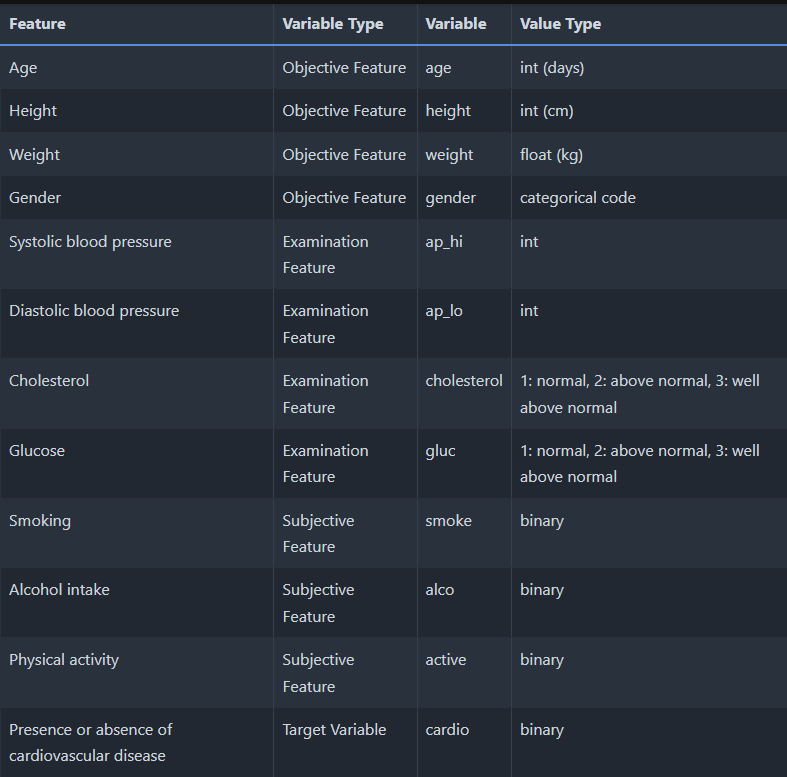

In [3]:
# Import all required modules
# Disable warnings
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

# Import plotting modules and set up
import seaborn as sns

sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", font_scale=1.5, rc={"figure.figsize": (11, 8), "axes.titlesize": 18}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

In [4]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [5]:
df = pd.read_csv(DATA_PATH + "mlbootcamp5_train.csv", sep=";")
print("Dataset size: ", df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 1. Предварительный анализ. 

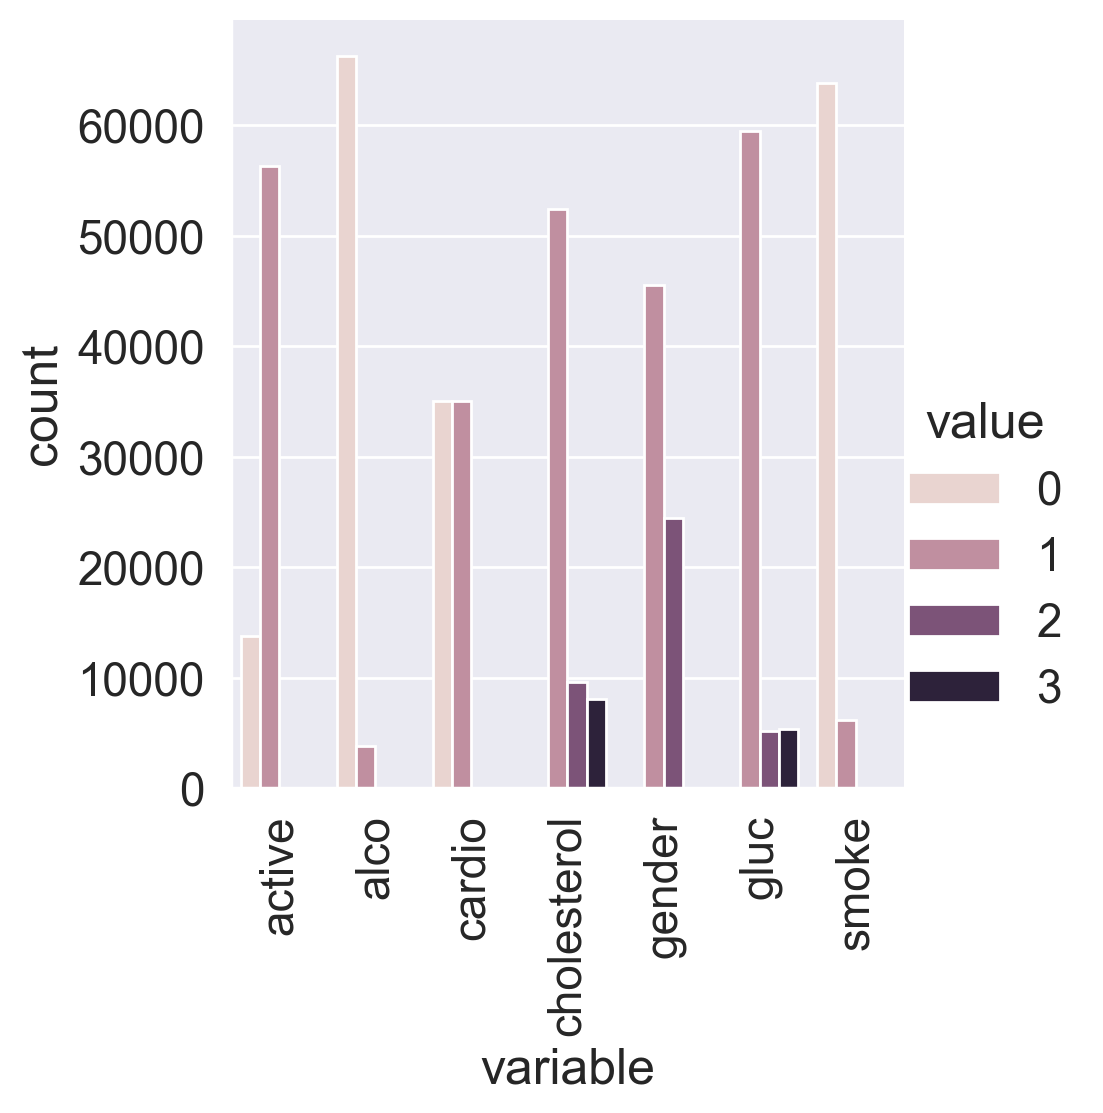

In [ ]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.catplot(
    x="variable", y="count", hue="value", data=df_uniques, kind="bar"
)
plt.xticks(rotation='vertical');

Можно заметить, что целевая категория cardio разделена равномерно. Большинство респонзентов занимаются физической активностью, не пьют, не курят. Холестирин и глюкоза у большинства в норме. Рассмотрим процентные соотношения:

In [8]:
print('Соотношение в категории физ.активность:',df['active'].value_counts(normalize=True))
print('Соотношение в категории алкоголь:',df['alco'].value_counts(normalize=True))
print('Соотношение в категории проблемы с сердцем:',df['cardio'].value_counts(normalize=True))


Соотношение в категории физ.активность: active
1    0.803729
0    0.196271
Name: proportion, dtype: float64
Соотношение в категории алкоголь: alco
0    0.946229
1    0.053771
Name: proportion, dtype: float64
Соотношение в категории проблемы с сердцем: cardio
0    0.5003
1    0.4997
Name: proportion, dtype: float64


In [9]:
print('Соотношение в категории холестирин:',df['cholesterol'].value_counts(normalize=True))
print('Соотношение в категории пол:',df['gender'].value_counts(normalize=True))
print('Соотношение в категории глюкоза:',df['gluc'].value_counts(normalize=True))
print('Соотношение в категории курение:',df['smoke'].value_counts(normalize=True))

Соотношение в категории холестирин: cholesterol
1    0.748357
2    0.136414
3    0.115229
Name: proportion, dtype: float64
Соотношение в категории пол: gender
1    0.650429
2    0.349571
Name: proportion, dtype: float64
Соотношение в категории глюкоза: gluc
1    0.849700
3    0.076157
2    0.074143
Name: proportion, dtype: float64
Соотношение в категории курение: smoke
0    0.911871
1    0.088129
Name: proportion, dtype: float64


Рассмотрим те же данные, но разделив респонзентов на две группы. У которых есть проблемы и у которых их нет.

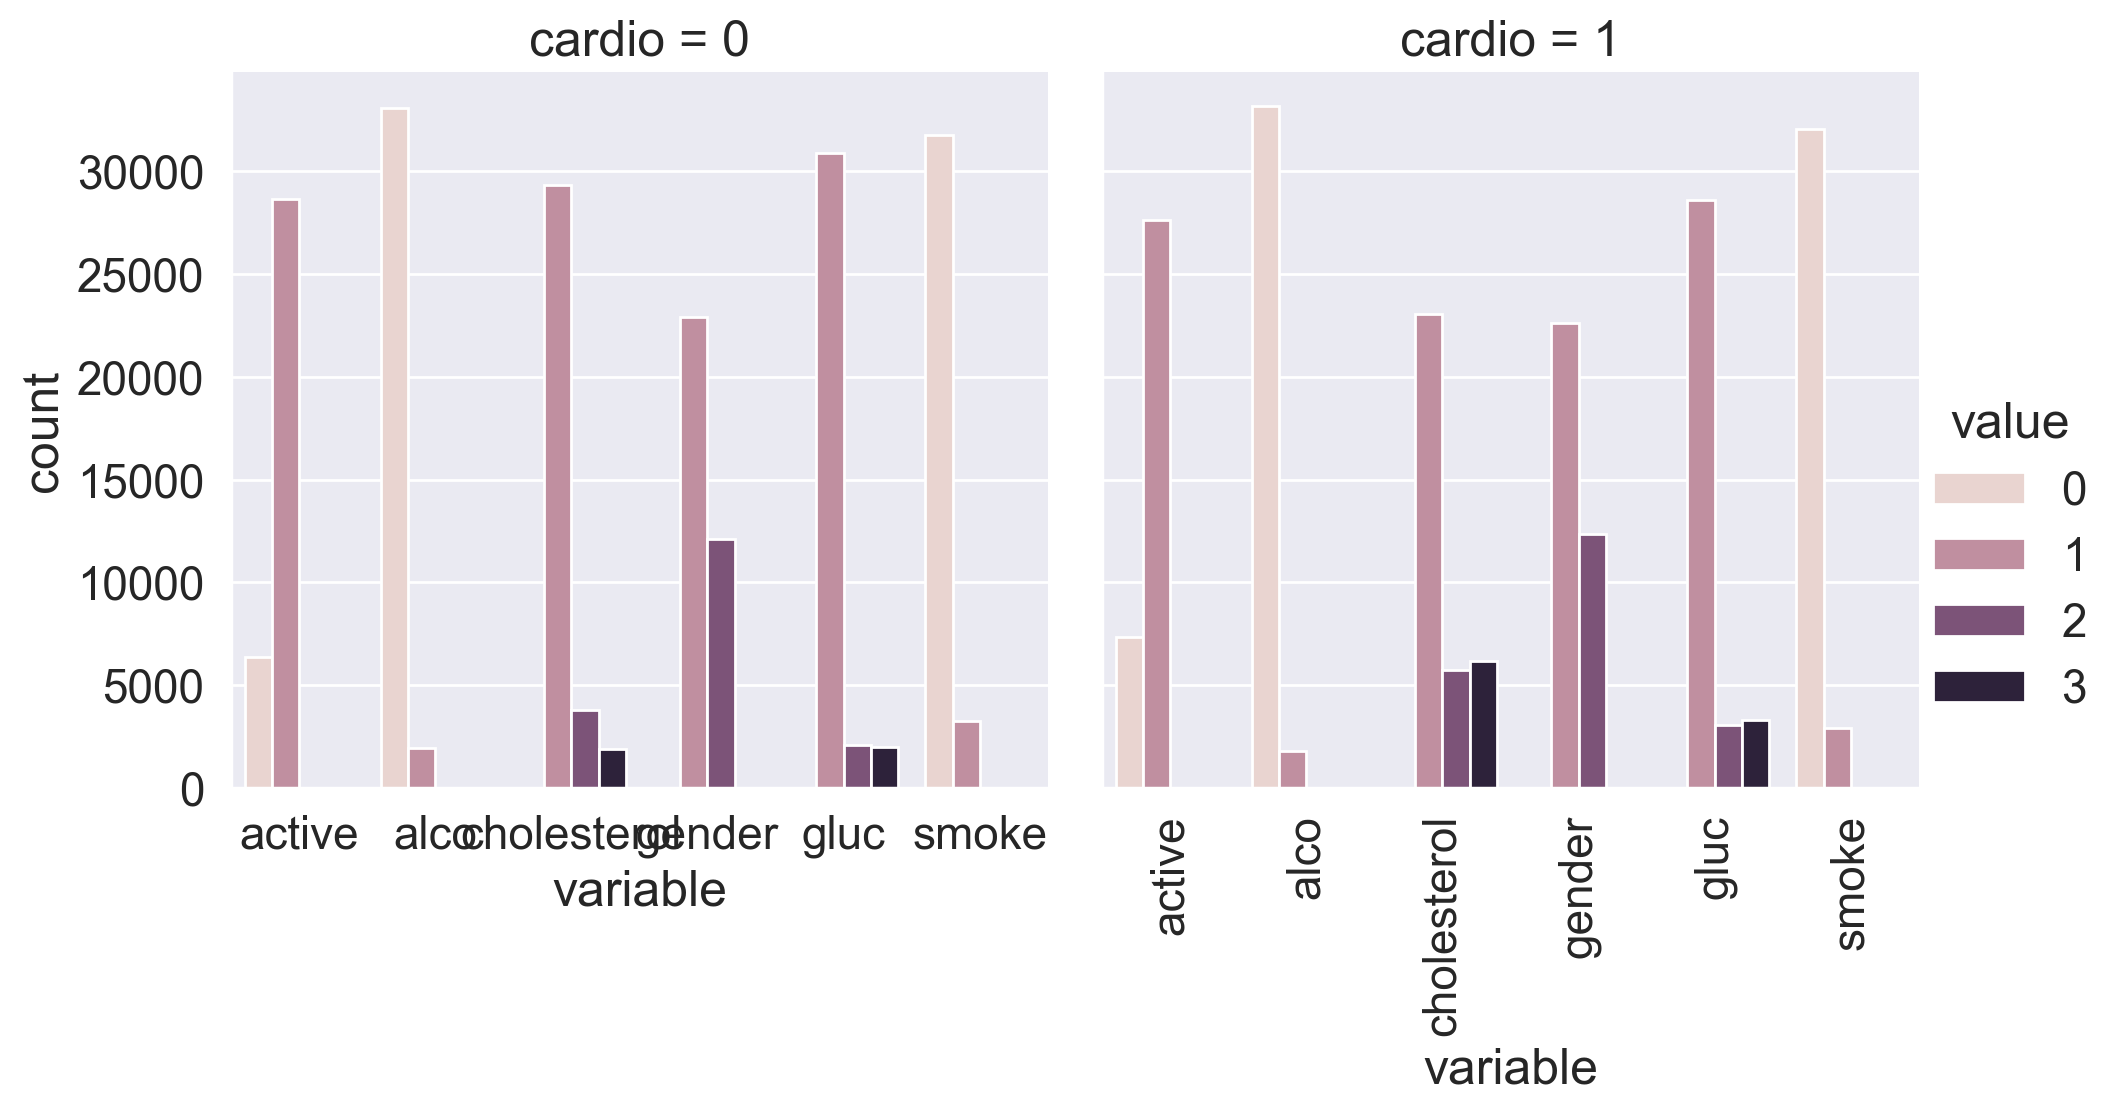

In [17]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active"],
    id_vars=["cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value", "cardio"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)
sns.catplot(
    x="variable",
    y="count",
    hue="value",
    col="cardio",
    data=df_uniques,
    kind="bar",
)
plt.xticks(rotation='vertical');

Заметна разница в категории глюкозы и холестирина. Может в этом решение задачи? Вычислим некоторую статистику для unique значений. 